In [1]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#variable="air.2m"
#variable="air.sfc"
#variable="apcp"
variable="rhum.2m"

In [4]:
# The temperature to be used for finding the viable transmission range
temperature= "air.2m"
#temperature= "air.sfc"

In [5]:
months=["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
years=range(1999, 2016)

In [6]:
# Importing WNV data
df= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/Arbovirus_risk_modeling_US/WNV_human_cases/WNV_NI_NNI_1999to2015_prevalence_incidence_final_20180530.csv", encoding='latin-1')
df=df[df["Select_County"]==1]
df.rename(columns = {'GEOID10':'GEOID'}, inplace = True)

In [7]:
# Defining Virus tramission temperarture range(in Fahrenheit)
a=60
b=90

In [8]:
# Converting Fahrenheit to Kelvin
a=(a-32)*5/9 + 273
b=(b-32)*5/9 + 273

In [9]:
temp= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/" + "air.2m" +"/"+ "1999" + "_" + "01" + ".csv")

In [10]:
# For CDD and CP
df_mod=df.copy()
for j in years:
    for k in range(len(months)):
        #Importing monthly temperature data
        temp= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/" + temperature +"/"+ str(j) + "_" + months[k] + ".csv")
        #Importing monthly precipitation data
        prec=pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/apcp/"+ str(j) + "_" + months[k] + ".csv")
        # Only considering mean values
        temp=temp[["GEOID", "mean"]]
        temp.rename(columns = {'mean':'mean_temp_' + str(j) + "_" + months[k]}, inplace = True)
        prec=prec[["GEOID", "mean"]]
        prec.rename(columns = {'mean':'mean_prec_' + str(j) + "_" + months[k]}, inplace = True)
        # Adding columns corresponding to all years and months
        df_mod=df_mod.join(temp.set_index('GEOID'), on='GEOID')
        df_mod=df_mod.join(prec.set_index('GEOID'), on='GEOID')

In [11]:
# Adding a column for incident year
incident_year=[2015 for i in range(len(df_mod))]
for j in range(len(df_mod)):
    for i in years:
        if(df_mod.iloc[j]["NI_IR_" + str(i)]!=0):
            incident_year[j]=i
            break
df_mod["Incident_year"]=incident_year

In [12]:
x_cdd=[]    #For storing cumulative degree days  
x_cp=[]     #For storing cumulative precipitation
y=[]        #For storing IR of WNV
for i in years:
    #Number of days in february
    feb=28
    #For leap year
    if(i%4==0):
        feb=29
    #Months with number of days
    days={"01":31, "02":feb, "03" :31, "04":30, "05":31, "06":30, "07":31, "08":31, "09":30, "10":31, "11":30, "12":31}
    for j in range(len(df_mod)):
        cdd=0
        cp=0
        # For all years after first incident year
        if(df_mod.iloc[j]["Incident_year"]<i):
            for k in months:
                if(df_mod.iloc[j]["mean_temp_" + str(i) + "_" + k]>=a and df_mod.iloc[j]["mean_temp_" + str(i) + "_" + k]<=b):
                    cdd=cdd + days[k]
                    cp=cp + df_mod.iloc[j]["mean_prec_" + str(i) + "_" + k]
            x_cdd.append(cdd)
            x_cp.append(cp)
            y.append(df_mod.iloc[j]["NI_IR_" + str(i)]) 

In [13]:
df_cdd=pd.DataFrame()
df_cp=pd.DataFrame()
df_cdd["IR"]=y
df_cdd["CDD"]=x_cdd
df_cp["IR"]=y
df_cp["CP"]=x_cp

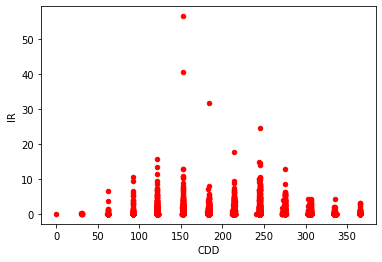

In [14]:
df_cdd.plot(kind='scatter',x='CDD',y='IR',color='red')

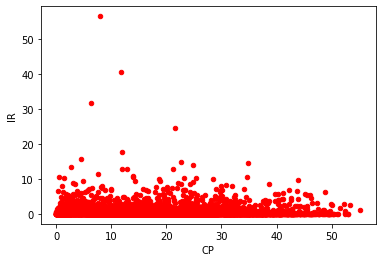

In [15]:
df_cp.plot(kind='scatter',x='CP',y='IR',color='red')

In [16]:
# For plotting standard deviations of the variable
df_mod=df.copy()
for j in years:
    for k in range(len(months)):
        #Importing monthly temperature data
        temp= pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/" + temperature +"/"+ str(j) + "_" + months[k] + ".csv")
        #Importing monthly data for the variable
        var=pd.read_csv("/Users/sparshagarwal/Downloads/WMV_data/intersections/" + variable +"/"+ str(j) + "_" + months[k] + ".csv")
        # Only considering mean values
        temp=temp[["GEOID", "mean"]]
        temp.rename(columns = {'mean':'mean_temp_' + str(j) + "_" + months[k]}, inplace = True)
        var=var[["GEOID", "mean"]]
        var.rename(columns = {'mean':'mean_' + str(j) + "_" + months[k]}, inplace = True)
        # Adding columns corresponding to all years and months
        df_mod=df_mod.join(temp.set_index('GEOID'), on='GEOID')
        df_mod=df_mod.join(var.set_index('GEOID'), on='GEOID')

In [17]:
# Adding a column for incident year
incident_year=[2015 for i in range(len(df_mod))]
for j in range(len(df_mod)):
    for i in years:
        if(df_mod.iloc[j]["NI_IR_" + str(i)]!=0):
            incident_year[j]=i
            break
df_mod["Incident_year"]=incident_year

In [18]:
x=[]        #For storing temperature/precipitation/humidity standard deviation 
y=[]        #For storing IR of WNV
for i in years:
    for j in range(len(df_mod)):
        temp_list=[]
        # For all years after first incident year
        if(df_mod.iloc[j]["Incident_year"]<i):
            if(df_mod.iloc[j]["NI_IR_" + str(i)]>0):     #Removing IR=0 instances
                for k in months:
                    if(df_mod.iloc[j]["mean_temp_" + str(i) + "_" + k]>=a and df_mod.iloc[j]["mean_temp_" + str(i) + "_" + k]<=b):
                        temp_list.append(df_mod.iloc[j]["mean_" + str(i) + "_" + k])
                if(len(temp_list)>0):
                        x.append(np.std(temp_list))
                        y.append(df_mod.iloc[j]["NI_IR_" + str(i)]) 

In [19]:
df_std=pd.DataFrame()
df_std["IR"]=y
df_std["Std"]=x

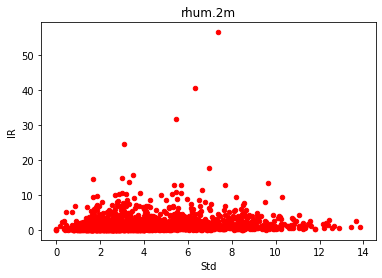

In [20]:
df_std.plot(kind='scatter',x='Std',y='IR',color='red', title= variable)

In [55]:
df_mod[df_mod["STNAME"]=="Michigan"]

,GEOID,Select_County,STATEFP10,STATENS,STUSPS,STNAME,COUNTYFP10,COUNTYNS10,CTYNAME,POPESTIMATE1999,...,mean_2015_08,mean_temp_2015_09,mean_2015_09,mean_temp_2015_10,mean_2015_10,mean_temp_2015_11,mean_2015_11,mean_temp_2015_12,mean_2015_12,Incident_year
1199,26005,1,26,1779789,MI,Michigan,5,1622945,Allegan County,104476,...,78.920509,293.420135,75.897667,285.661804,75.339294,281.313843,77.188919,278.028503,84.641754,2002
1205,26017,1,26,1779789,MI,Michigan,17,1622951,Bay County,110295,...,75.473557,293.267639,73.788353,284.795074,75.181473,280.201294,78.225449,277.027161,84.288300,2002
1207,26021,1,26,1779789,MI,Michigan,21,1622953,Berrien County,162028,...,78.884845,293.746631,76.206012,286.031592,73.820813,281.379150,76.360657,278.125732,83.762714,2005
1209,26025,1,26,1779789,MI,Michigan,25,1622955,Calhoun County,138021,...,79.564537,292.476105,74.457626,284.654694,72.551056,279.985046,76.049141,277.143341,84.245079,2015
1210,26027,1,26,1779789,MI,Michigan,27,1622956,Cass County,50852,...,79.108139,293.245636,74.357559,285.419495,72.671265,280.956207,75.057739,277.957642,83.088959,2002
1215,26037,1,26,1779789,MI,Michigan,37,1622961,Clinton County,64069,...,75.900154,292.585480,72.986794,284.375488,73.494987,279.465973,77.916595,276.513184,84.197266,2005
1219,26045,1,26,1779789,MI,Michigan,45,1622965,Eaton County,102991,...,77.369728,292.628510,72.932953,284.649139,71.808113,279.831390,76.338791,277.028809,83.987579,2002
1221,26049,1,26,1779789,MI,Michigan,49,1622967,Genesee County,434409,...,74.087158,292.873901,72.092850,284.472992,72.106377,279.708344,77.262299,276.899780,83.556190,2002
1229,26065,1,26,1779789,MI,Michigan,65,1622975,Ingham County,280035,...,75.430344,292.931641,71.435036,284.761932,70.762497,279.922089,76.022385,277.190155,83.419853,2002
1234,26075,1,26,1779789,MI,Michigan,75,1622980,Jackson County,157085,...,76.744558,292.940592,71.789571,284.873271,70.625570,280.095805,75.439077,277.347046,83.468282,2011


In [31]:
#Below section is for verification of NARR data, done by plotting monthly temperatures for different counties.

In [32]:
#new=df_mod[df_mod["CTYNAME"]== "Pinal County"]

In [33]:
#new=df_mod[df_mod["CTYNAME"]== "New York County"]

In [34]:
#new=df_mod[df_mod["CTYNAME"]== "Champaign County"]

In [56]:
county="Berrien County"

In [57]:
new=df_mod[df_mod["CTYNAME"]== county]

In [58]:
temp_dict={}

for i in years:
    temp=[]
    for j in months:
        temp.append((new.iloc[0]["mean_temp_" + str(i) + "_" + j] -273)*9/5 +32)
    temp_dict[i]=temp
    
month=[]
for j in months:
    month.append(int(j))

Text(0.5, 1.0, 'Berrien County')

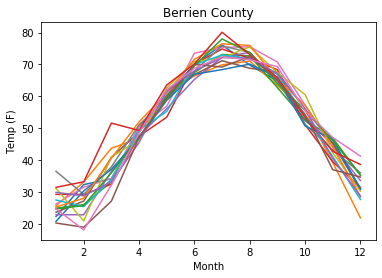

In [59]:
for i in years:
    plt.plot(month, temp_dict[i])
plt.xlabel("Month")
plt.ylabel("Temp (F)")
plt.title(county)